# Starbucks Capstone Challenge

## Description:

This notebook is done as the capstone project for Udacity Data Scientist Nanodegree. As a means to attract and retain customers, once every few days Starbucks provides a rewards program that honors regular customers with special offers not available to the standard customer. A customer who received the offer would be rewarded when his cumulated consumption over the designed threshold.

## Problem Statement:

The problem we are looking to solve here is to build a recommendation engine that recommends Starbucks which offer should be sent to a particular customer based on their purchasing decisions.

## Datasets:

The dataset is based on simulated data of consumer behaviour on the Starbucks rewards mobile application provided by Starbucks & Udacity and given in the form of three json files:<br>
1) portfolio.json: contains offer ids and meta data about each offer <br>
2) profile.json: contains information about customers<br>
3) transcript.json: records for transactions, offers received, offers viewed, and offers completed

# Some Basic Questions About The Dataset

Which year has the most members?<br>
Who gets highest paying based on gender?<br>
Which type of offers each gender receives?<br>
What is the common offer depending on age?<br>
How long did the users become members? (in term of days)<br>
What is salary ranges for customers across different age?<br>
What is the correlation between amount spent and open days?<br>
Who takes longer time to acheive an offer depending on gender?<br>
How many offers are completed depending on all offers customers viewed?<br>
What is the correlation between offer open days and amount spent in dollars?<br>

## Starategy:

The starategy of solving this problem is as follows:<br>

1) Data Exploration<br>
2) Quick Exploratory Data Analysis<br>
3) Data Preprocessing<br>
4) More EDA On The Cleaned Dataset<br>
5) Machine Learning<br>
6) Data Evaluatin<br>

Import all the necessary libraries

In [1]:
import json
import math
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import datetime
from datetime import datetime

In [3]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, Imputer

In [4]:
sns.set(style='darkgrid')
sns.set_palette('husl')

In [5]:
% matplotlib inline

In [6]:
from IPython.core.pylabtools import figsize
figsize(19, 5)

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
# read the json files
portfolio = pd.read_json('data/portfolio.json', orient = 'records', lines = True)
profile = pd.read_json('data/profile.json', orient = 'records', lines = True)
transcript = pd.read_json('data/transcript.json', orient = 'records', lines = True)

# Data Exploration

### Portfolio Dataset

In [9]:
# display the first rows of portfolio
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [10]:
# explore datatypes and check for null values 
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 552.0+ bytes


The channels coulmn refers to the way in which the offer is sent to customers through like mobil, email, social and web. Each offer has different difficulty and reward. The difficulty is the minimum required spend to complete an offer in terms of dollars while the duration is time for offer to be open in terms of days. Now let's check all the offer_types that are offered.

In [11]:
# display all offer types
portfolio['offer_type'].unique()

array([u'bogo', u'informational', u'discount'], dtype=object)

So we have three different offer types:
<li>BOGO - buy one get one free</li>
<li>Discount - discount with purchase</li>
<li>Informational - provides information about products</li>

### Profile Dataset

In [12]:
# explore profile dataset
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
# explore datatypes and check for completeness
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


So 17,000 customers were contained in profile and their personal inforamtion, some customers has no information relevant to gender and income, and became_member_on shows the date when customer created an app account, last thing is this table need to be cleaned as it has some null values embedded in gender and income columns that need to be removed

In [14]:
# show all types of genter
profile['gender'].unique()

array([None, u'F', u'M', u'O'], dtype=object)

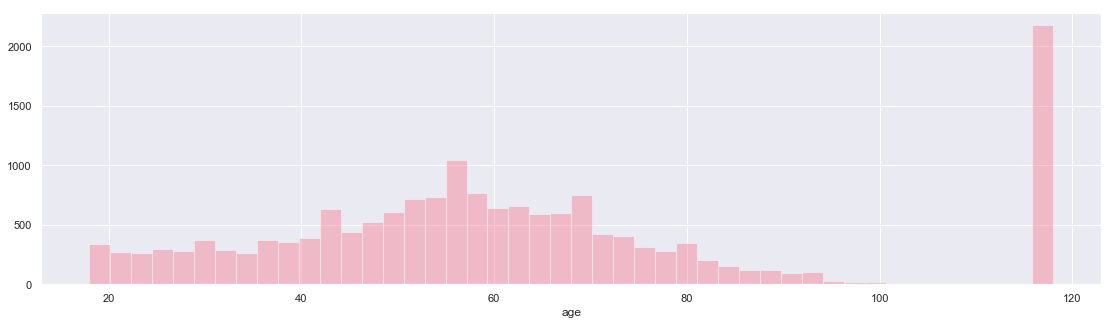

In [15]:
# show age distribution
sns.distplot(profile['age'], kde = False)

Above plot shows some values that out of the normal distribution

### Transcript Dataset

In [16]:
# display first few recoreds
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{u'offer id': u'9b98b8c7a33c4b65b9aebfe6a799e6...
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{u'offer id': u'0b1e1539f2cc45b7b9fa7c272da2e1...
2,offer received,e2127556f4f64592b11af22de27a7932,0,{u'offer id': u'2906b810c7d4411798c6938adc9daa...
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{u'offer id': u'fafdcd668e3743c1bb461111dcafc2...
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{u'offer id': u'4d5c57ea9a6940dd891ad53e9dbe8d...


In [17]:
# check datatypes & completeness
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


So time coulmn refers to the number of hours after start of test (need to be convered into days), and value column refers to different values depending on the event type, so now let's check out the unique values of event column.

In [18]:
# check out the event types
transcript['event'].unique()

array([u'offer received', u'offer viewed', u'transaction',
       u'offer completed'], dtype=object)

Now, the value column will have to be preprocessed depending on the event.

# Quick EDA

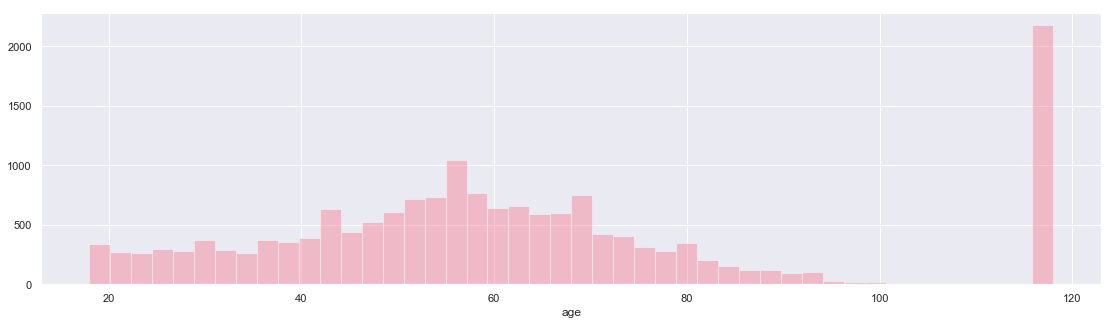

In [19]:
# check age distribution
sns.distplot(profile['age'], kde = False)

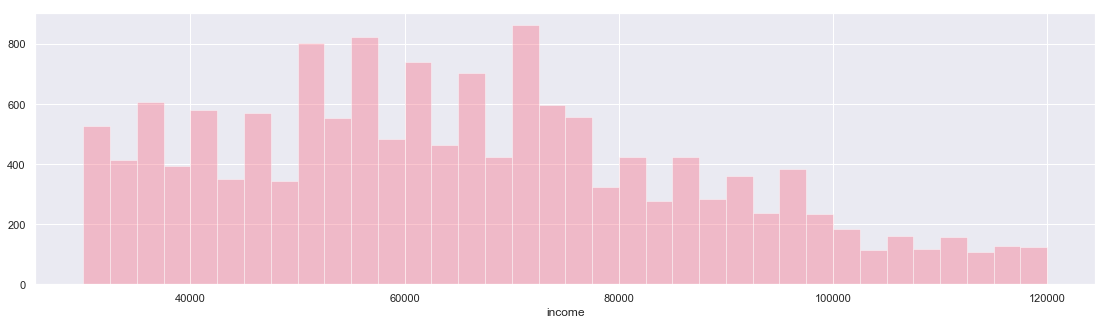

In [20]:
# check income distribution
sns.distplot(profile['income'].dropna(), kde = False)

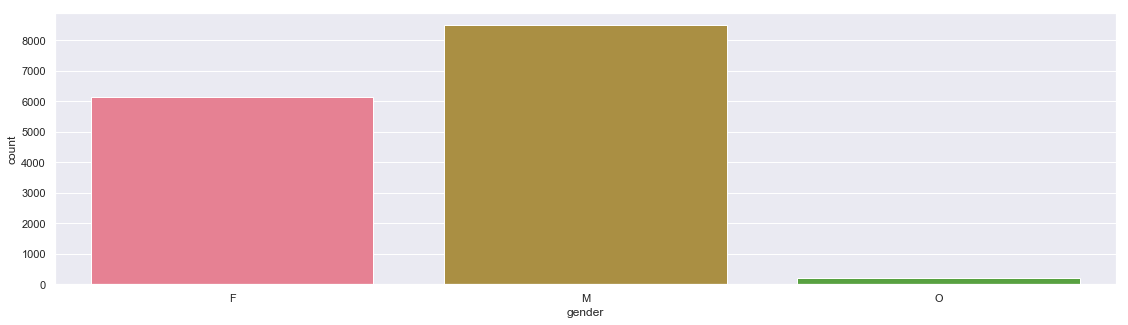

In [21]:
# check gender count
sns.countplot(data = profile, x = 'gender')

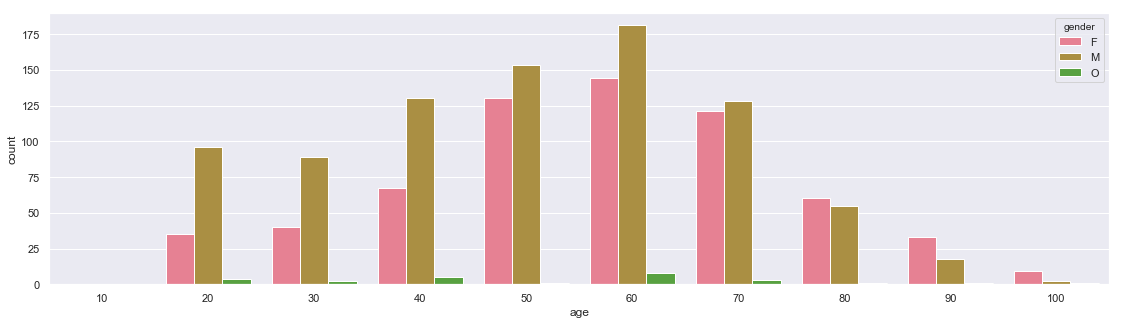

In [22]:
# age distribution of the customers
sns.countplot(x = 'age', hue = 'gender', data = profile, order = [10,20,30,40,50,60,70,80,90,100])

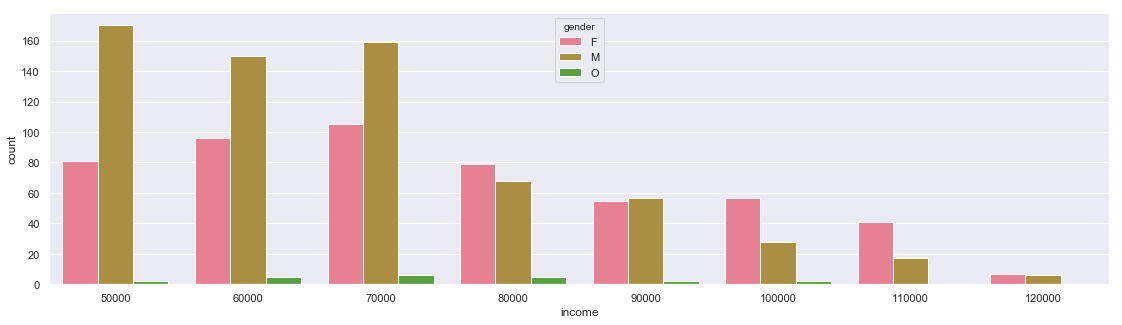

In [23]:
# who gets highest paying based on gender?
sns.countplot(x ='income', hue = 'gender', data = profile, order = [50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000])

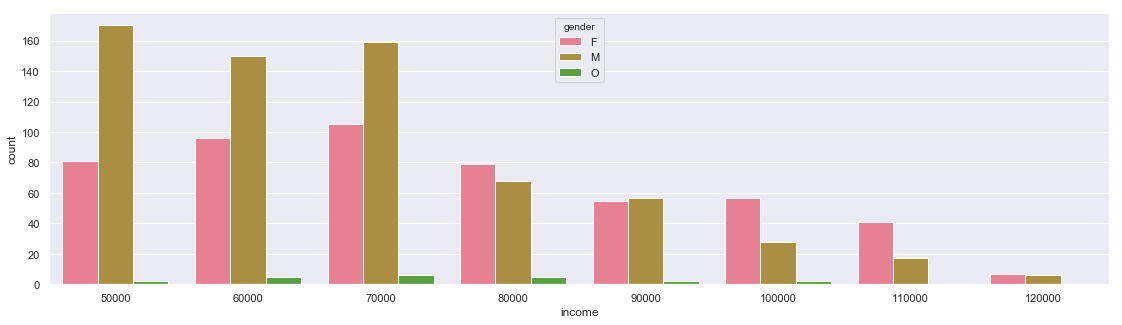

In [24]:
# salary ranges for customers across different age?
sns.countplot(x = 'income', hue = 'gender', data = profile, order = [50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000])

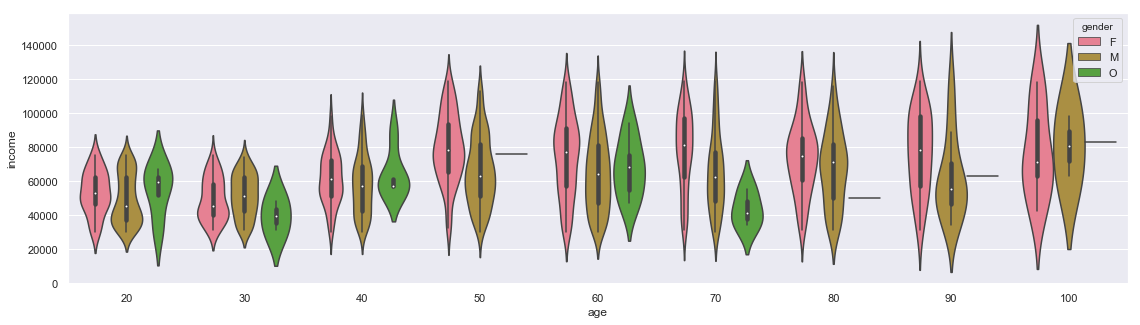

In [25]:
# gender/income/age distribution
# plt.figure(figsize=(19, 5))
sns.violinplot(profile['age'], profile['income'], hue = profile['gender'], order = [20, 30, 40, 50, 60, 70, 80, 90, 100])

# Data Preprocessing

### Portfolio Dataset

There is no much to change in this daatset except:
1) changing the name of id column to more meaningful name such as 'offer_id' beacuse otherwise it would be mixed up with the other id coulmn of profile dataset
2) encode offer_type and channels columns so to can feed them to our model

In [26]:
# change id column name to offer_id
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [27]:
# encode offer_type
offer_dummies = pd.get_dummies(portfolio['offer_type'])
portfolio = pd.concat([portfolio, offer_dummies], axis = 1)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0


In [28]:
# before encoding channels we need to convert the channels lables into individual columns
channel_lables = MultiLabelBinarizer()
# encode channel_lables
enc_channles = channel_lables.fit_transform(portfolio['channels'])
# create a new dataframe for encoded channel labels
enc_labels_df = pd.DataFrame(data = enc_channles, columns = channel_lables.classes_)
# concatenate this dateframe to portfolio
portfolio = pd.concat([portfolio, enc_labels_df], axis = 1)
portfolio.drop('channels', axis = 1, inplace = True)
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,bogo,discount,informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1,0,0,1


### Profile Dataset

To clean this dataset we first need to drop all null values, then change the name id coulmn to 'customer_id', then converting became_member_on from int into datetime to calculate the customer membership duration in days since joining

In [29]:
# check null values agian
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [30]:
# drop all null values
profile.dropna(inplace = True)
profile.isnull().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [31]:
# change id coulmn name
profile.rename(columns = {'id': 'customer_id'}, inplace = True)
profile.head()

,age,became_member_on,gender,customer_id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [32]:
# convert became_member_on column from int into datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile.head()

,age,became_member_on,gender,customer_id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [33]:
# extract the year portion of the joined date
profile['joined_year'] = profile['became_member_on'].dt.year

In [34]:
# show the date as the number of days since the signup date
profile['member_since'] = (datetime.today() - profile.became_member_on).dt.days
# profile.drop('became_member_on', axis = 1, inplace = True)
profile.head()

,age,became_member_on,gender,customer_id,income,joined_year,member_since
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,849
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,916
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,564
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,640
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,730


In [35]:
# encode gender column
le = preprocessing.LabelEncoder()
profile['gender'] = le.fit_transform(profile['gender'])
profile.head()

,age,became_member_on,gender,customer_id,income,joined_year,member_since
1,55,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,849
3,75,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,916
5,68,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,564
8,65,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,640
12,58,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,730


### Transcript Dataset

To clean this dataset we need to change the name of person column to 'cunstomer_id', 2) convert time coulmn into number of days, 3) then finally we need to split value coulmn into offer_id and amount so we can form new dataframes for offer_transcripts and amount_transcripts

In [36]:
# chnage person column name to customer_id
transcript.rename(columns = {'person': 'customer_id'}, inplace = True)
transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{u'offer id': u'9b98b8c7a33c4b65b9aebfe6a799e6...
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{u'offer id': u'0b1e1539f2cc45b7b9fa7c272da2e1...
2,offer received,e2127556f4f64592b11af22de27a7932,0,{u'offer id': u'2906b810c7d4411798c6938adc9daa...
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{u'offer id': u'fafdcd668e3743c1bb461111dcafc2...
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{u'offer id': u'4d5c57ea9a6940dd891ad53e9dbe8d...


In [37]:
# convert time into days
transcript['days'] = transcript['time'] / 24
transcript.drop(columns = ['time'], inplace = True)
transcript.head()

,event,customer_id,value,days
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,{u'offer id': u'9b98b8c7a33c4b65b9aebfe6a799e6...,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,{u'offer id': u'0b1e1539f2cc45b7b9fa7c272da2e1...,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,{u'offer id': u'2906b810c7d4411798c6938adc9daa...,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,{u'offer id': u'fafdcd668e3743c1bb461111dcafc2...,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,{u'offer id': u'4d5c57ea9a6940dd891ad53e9dbe8d...,0.0


In [38]:
# encode values column
event_dummies = pd.get_dummies(transcript['event'])
transcript = pd.concat([transcript, event_dummies], axis = 1)
transcript.head()

,event,customer_id,value,days,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,{u'offer id': u'9b98b8c7a33c4b65b9aebfe6a799e6...,0.0,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,{u'offer id': u'0b1e1539f2cc45b7b9fa7c272da2e1...,0.0,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,{u'offer id': u'2906b810c7d4411798c6938adc9daa...,0.0,0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,{u'offer id': u'fafdcd668e3743c1bb461111dcafc2...,0.0,0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,{u'offer id': u'4d5c57ea9a6940dd891ad53e9dbe8d...,0.0,0,1,0,0


In [39]:
# spilt value coulmn into values and keys where keys are amount or offer and values are offer_id or amount
transcript['key'] = transcript['value'].apply(lambda x: list(x.keys())[0])
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0])

In [40]:
# create a new dataframe for offer_transcripts
offer_transcripts = transcript[transcript['key'] == 'offer id']
offer_transcripts.rename(columns = {'value': 'offer_id'}, inplace = True)
# offer_transcripts.drop(columns = ['key', 'event', 'offer completed', 'offer received', 'offer viewed', 'transaction'], inplace = True)
offer_transcripts.head()

,event,customer_id,offer_id,days,offer completed,offer received,offer viewed,transaction,key
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0,0,offer id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0,0,offer id
2,offer received,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0,0,offer id
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,1,0,0,offer id
4,offer received,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,1,0,0,offer id


In [41]:
# create a new dataframe for amount_transcripts
amount_transcripts = transcript[transcript['key'] == 'amount']
amount_transcripts.rename(columns = {'value': 'amount'}, inplace = True)
# amount_transcripts.drop(columns = ['key', 'event', 'offer completed', 'offer received', 'offer viewed'], inplace = True)
amount_transcripts.head()

,event,customer_id,amount,days,offer completed,offer received,offer viewed,transaction,key
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0.83,0.0,0,0,0,1,amount
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56,0.0,0,0,0,1,amount
12659,transaction,54890f68699049c2a04d415abc25e717,13.23,0.0,0,0,0,1,amount
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,19.51,0.0,0,0,0,1,amount
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,18.97,0.0,0,0,0,1,amount


In [42]:
# combine portfolio and transcript datasets using a unique offer_id
transcript.rename(columns = {'value': 'offer_id'}, inplace = True)
master_set = transcript.merge(portfolio, how = 'left', on = 'offer_id')

In [43]:
# join 'master_set' dataset with 'profile' on 'customer_id'
master_set = master_set.merge(profile, how = 'left', on = 'customer_id')

In [44]:
master_set.to_csv('master_set.csv', index = False)

In [45]:
master_set = pd.read_csv('master_set.csv')

# Some More EDA On The Cleaned Dataset

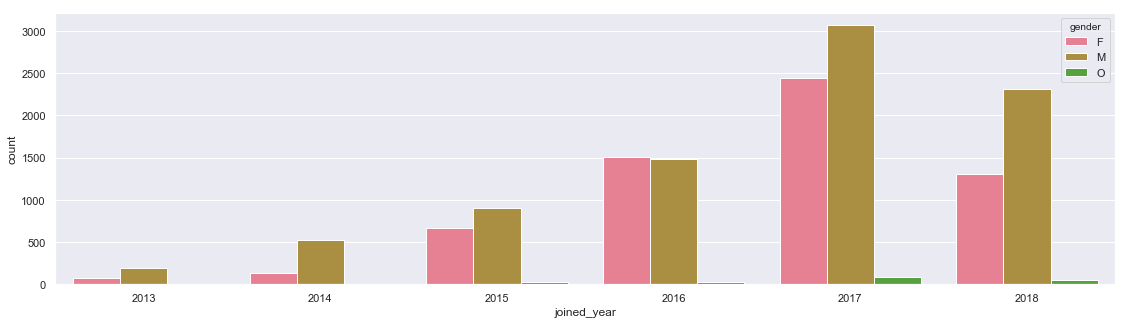

In [46]:
# which year has the most members?
profile['gender'] = le.inverse_transform(profile['gender'])
profile['joined_year'] = profile['became_member_on'].dt.year
sns.countplot(x = 'joined_year', hue = 'gender', data = profile)

In [47]:
# go back to the encodeing mode
le = preprocessing.LabelEncoder()
profile['gender'] = le.fit_transform(profile['gender'])

Text(0.5,1,'Most popular offers depending on customers age')

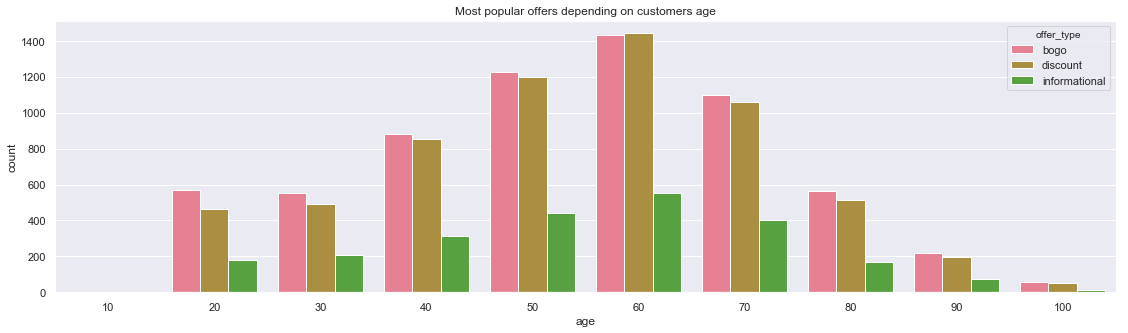

In [48]:
# what is the common offer depending on age
sns.countplot(x ='age', hue = 'offer_type', data = master_set, order = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.title('Most popular offers depending on customers age')

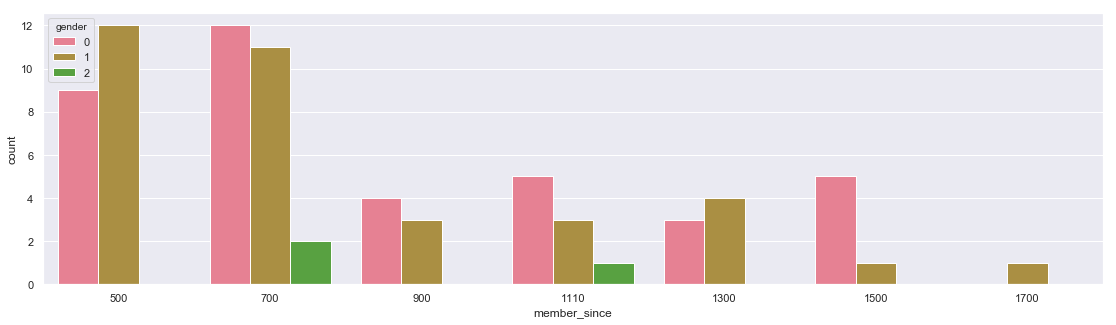

In [49]:
# how long did the users become members? (in term of days)
sns.countplot(x = 'member_since', hue = 'gender', data = profile, order = [500, 700, 900, 1110, 1300, 1500, 1700])

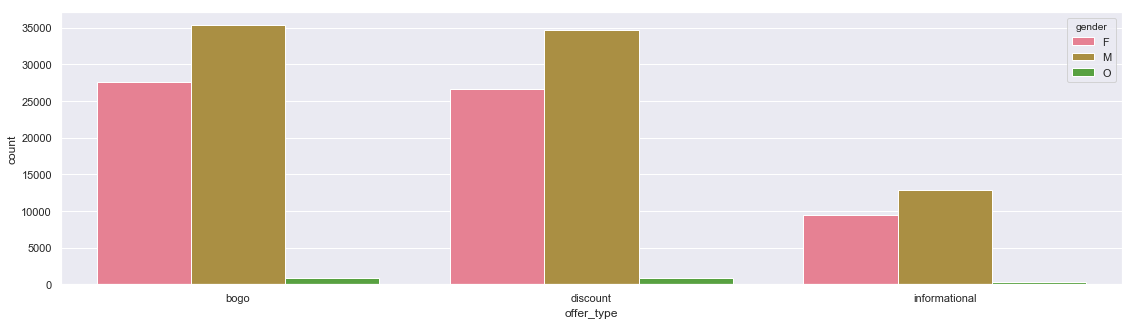

In [50]:
# who takes longer time to acheive an offer depending on gender?
master_set['gender'] = master_set['gender'].map({0:'F', 1:'M', 2:'O'}) 
sns.countplot(x = 'offer_type', hue = 'gender', data = master_set)

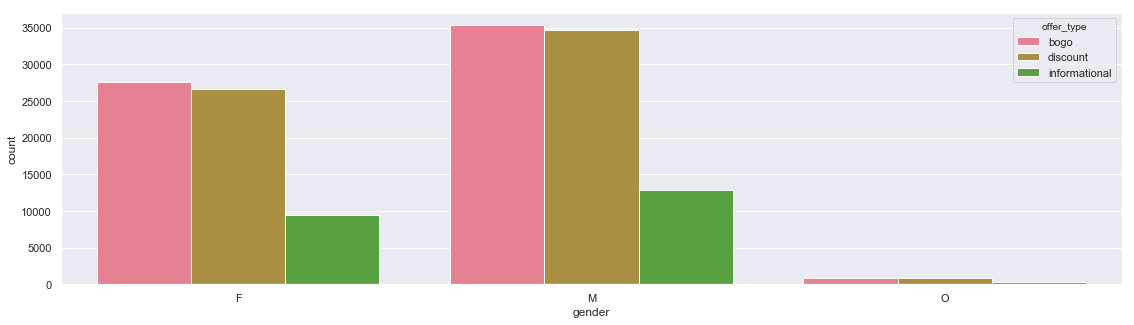

In [51]:
# which type of offers each gender receives?
sns.countplot(x = 'gender', hue = 'offer_type', data = master_set)

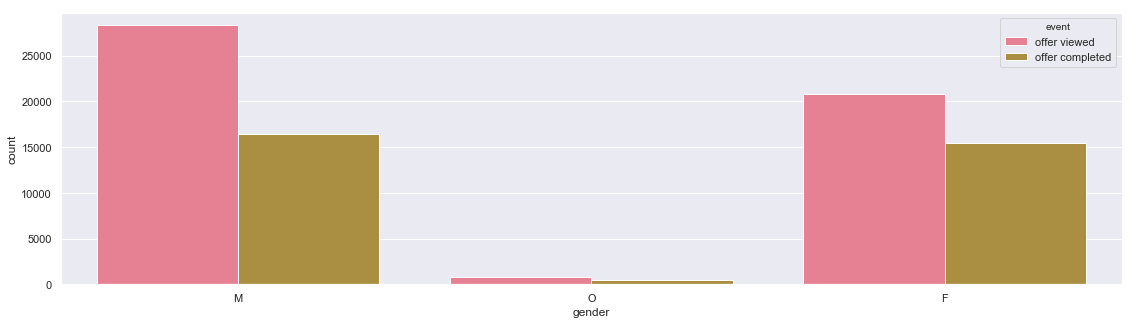

In [52]:
# how many offers are completed depending on all offers customers viewed?
master_set = master_set[master_set['event'] != 'transaction']
master_set = master_set[master_set['event'] != 'offer received']
sns.countplot(x = 'gender', hue = 'event', data = master_set)

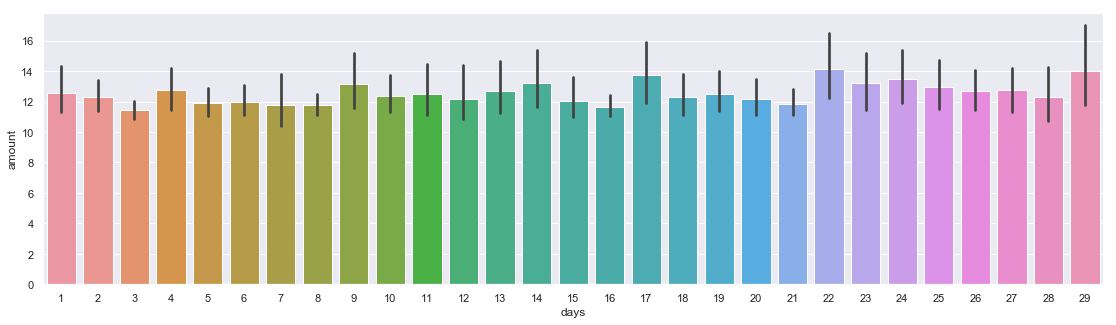

In [53]:
# what is the correlation b/w offer open days vs amount spent in dollars?
sns.barplot(amount_transcripts['days'], amount_transcripts['amount'], order = range(1, 30, 1))

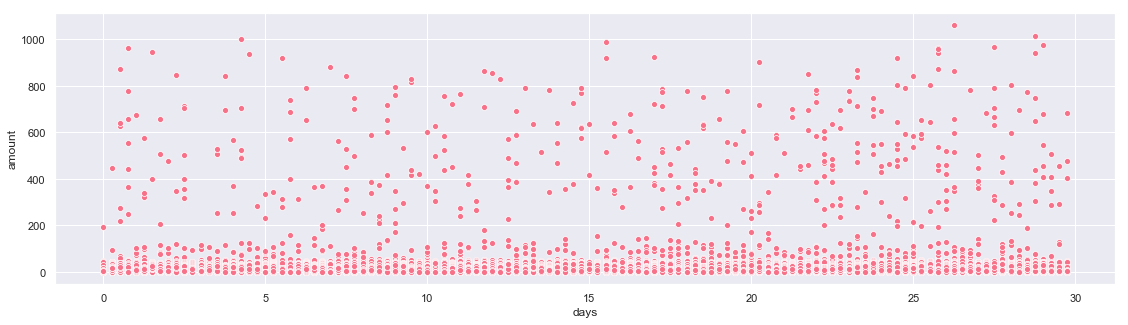

In [54]:
# correlation between amount spent no. of open days
sns.scatterplot(data = amount_transcripts, x = 'days', y = 'amount')

# Machine Learning Modelling

Before start our modelling we need to create a function (customer_transactions) that will collect customer transactions to build the master dataset

In [55]:
def customer_transactions(ids, portfolio = portfolio, profile = profile, offer_transcripts = offer_transcripts, amount_transcripts = amount_transcripts):
    
    # empty list to append customer data
    # variables initialisation
    customer_info = []
    discounts_num = 0
    bogos_num = 0

    # get customer details from profile dataset
    for customer_id in ids:
        customer_credentials = profile[profile['customer_id'] == customer_id]
        age = customer_credentials['age'].values[0]
        gender = customer_credentials['gender'].values[0]
        income = customer_credentials['income'].values[0]
        member_since = customer_credentials['member_since'].values[0]

#         #Initializing variables we will use later on down
#         discounts_num = 0
#         bogos_num = 0

        # get some new data from amount_transcripts and offer_transcripts
        total_viewed = offer_transcripts[offer_transcripts['customer_id'] == customer_id]['offer viewed'].sum()
        total_received = offer_transcripts[offer_transcripts['customer_id'] == customer_id]['offer received'].sum()
        total_completed = offer_transcripts[offer_transcripts['customer_id'] == customer_id]['offer completed'].sum()
        total_spent = amount_transcripts[amount_transcripts['customer_id'] == customer_id]['amount'].sum()
        avg_spent = amount_transcripts[amount_transcripts['customer_id'] == customer_id]['amount'].mean()
        num_transactions = amount_transcripts[amount_transcripts['customer_id'] == customer_id]['transaction'].sum()

        # get the percentage of completed bogo & discount offers
        if total_viewed > 0:
            percent_completed = total_completed / total_received
        else:
            percent_completed = 0

        # calculate the completed offers in order to calculate the completed bogos & completed discounts
        offer_completed_df = offer_transcripts[offer_transcripts['customer_id'] == customer_id]
        completed_offer_list = offer_completed_df['offer_id'].tolist()
        completed_bogo = portfolio[portfolio['offer_id'].isin(completed_offer_list)]['bogo'].sum()
        completed_discount = portfolio[portfolio['offer_id'].isin(completed_offer_list)]['discount'].sum()

        # get all the offers received by each customer
        offers_received = offer_transcripts[offer_transcripts['customer_id'] == customer_id]['offer_id'].values.tolist()

        # get the type of each offer (whether it's bogo or discount)
        for i in offers_received:
            # iterate through all bogo offers
            if i in ['ae264e3637204a6fb9bb56bc8210ddfd', '4d5c57ea9a6940dd891ad53e9dbe8da0', '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'f19421c1d4aa40978ebb69ca19b0e20d']:
                bogos_num += 1
            # iterate through all discount offers
            elif i in ['0b1e1539f2cc45b7b9fa7c272da2e1d7', '2298d6c36e964ae4a3e7e9706d1fb8c2', 'fafdcd668e3743c1bb461111dcafc2a4', '2906b810c7d4411798c6938adc9daaa5']:
                discounts_num += 1

        # get the percentage of bogo & discount offers completed vs how many of each were offered
        if bogos_num > 0:
            bogo_percent_completed = completed_bogo / bogos_num
        else:
            bogo_perecent_completed = 0.0

        if discounts_num > 0:
            discount_percent_completed = completed_discount / discounts_num
        else:
            discount_percent_completed = 0.0

        # put all data together
        customer_data = {'customer_id': customer_id,
                        'age': age,
                        'gender': gender,
                        'income': income,
                        'member_since': member_since,
                        'total_completed': total_completed,
                        'total_viewed': total_viewed,
                        'total_received': total_received,
                        'percent_completed': percent_completed,
                        'total_spent': total_spent,
                        'avg_spent': avg_spent,
                        'num_transactions': num_transactions,
                        'completed_bogo': completed_bogo,
                        'bogos_num': bogos_num,
                        'bogo_percent_completed': bogo_percent_completed,
                        'completed_discount': completed_discount,
                        'discounts_num': discounts_num,
                        'discount_percent_completed': discount_percent_completed}

        # append new data to customer_info
        customer_info.append(customer_data)
    
    # convert customer_info list into a dataframe
    customer_transactions = pd.DataFrame(customer_info)
    
    return customer_transactions

In [56]:
ids = profile['customer_id'].to_list()
master = customer_transactions(ids)
master.head()

,age,avg_spent,bogo_percent_completed,bogos_num,completed_bogo,completed_discount,customer_id,discount_percent_completed,discounts_num,gender,income,member_since,num_transactions,percent_completed,total_completed,total_received,total_spent,total_viewed
0,55,25.670000,1,1,1,0,0610b486422d4921ae7d2bf64640c50b,0.0,0,0,112000.0,848,3,0,0,2,77.01,0
1,75,22.752857,0,7,3,0,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,0,100000.0,915,7,0,0,4,159.27,4
2,68,19.243333,0,9,1,2,e2127556f4f64592b11af22de27a7932,0.0,4,1,70000.0,563,3,0,0,4,57.73,3
3,65,12.143333,0,17,2,2,389bc3fa690240e798340f5a15918d5c,0.0,8,1,53000.0,639,3,0,0,6,36.43,6
4,58,3.905000,0,17,0,2,2eeac8d8feae4a8cad5a6af0499a211d,0.0,12,1,51000.0,729,4,0,0,3,15.62,2


In [57]:
master.to_csv('master.csv', index = False)

In [58]:
master = pd.read_csv('master.csv')

In [59]:
master.drop(columns = 'customer_id', inplace = True)

Next step is to normalise the numerical values to ensure data will all be on the same scale

In [60]:
# replace missing values with means
imputer = Imputer(strategy = 'median')
imputed_df = pd.DataFrame(imputer.fit_transform(master))

In [61]:
# initialise a scaler
scaler = StandardScaler()
# fit and transform scaling on data
scaled_data = scaler.fit_transform(imputed_df)
scaled_data

array([[ 0.03488876,  0.63820631,  3.99527753, ..., -2.31304676,
        -0.30792521, -2.6045925 ],
       [ 1.18543027,  0.4598592 , -0.2502955 , ..., -0.45198908,
         0.3250357 ,  0.49312782],
       [ 0.78274074,  0.24529534, -0.2502955 , ..., -0.45198908,
        -0.45627783, -0.28130226],
       ...,
       [-0.31027369, -0.62749485,  3.99527753, ..., -1.38251792,
        -0.59470436, -1.83016242],
       [ 1.64564687, -0.10291241, -0.2502955 , ..., -1.38251792,
         0.55895269, -0.28130226],
       [ 0.43757829,  0.52612071, -0.2502955 , ..., -0.45198908,
         0.19999783, -1.05573234]])

In [62]:
# get the scaled data back into dataframe
column_names = master.columns.values.tolist()
master_transactions = pd.DataFrame(scaled_data, columns = column_names)
master_transactions.head()

,age,avg_spent,bogo_percent_completed,completed_bogo,completed_discount,discount_percent_completed,gender,income,member_since,num_bogos,num_discounts,num_transactions,percent_completed,total_completed,total_received,total_spent,total_viewed
0,0.034889,0.638206,3.995278,-0.564000,-1.711274,-0.351955,-1.159778,2.157419,-0.349433,-1.086118,-1.512168,-1.034512,0.0,0.0,-2.313047,-0.307925,-2.604592
1,1.185430,0.459859,-0.250296,1.746709,-1.711274,-0.351955,-1.159778,1.601801,-0.189601,1.299248,-1.512168,-0.262682,0.0,0.0,-0.451989,0.325036,0.493128
2,0.782741,0.245295,-0.250296,-0.564000,0.582649,-0.351955,0.770364,0.212756,-1.029314,-0.609045,0.475013,-1.034512,0.0,0.0,-0.451989,-0.456278,-0.281302
3,0.610160,-0.188782,-0.250296,0.591354,0.582649,-0.351955,0.770364,-0.574370,-0.848012,2.253394,0.475013,-1.034512,0.0,0.0,1.409069,-0.620174,2.041988
4,0.207470,-0.692454,-0.250296,-1.719354,0.582649,-0.351955,0.770364,-0.666973,-0.633313,-1.563191,0.475013,-0.841554,0.0,0.0,-1.382518,-0.780299,-1.055732


In [63]:
# save scaled data
master_transactions.to_csv('master_transactions.csv', index = False)
# master_transactions.to_csv('customer_transactions_scaled.csv', index = False)
# customer_transactions_master.to_csv('customer_transactions_scaled.csv', index = False)

First, let's have an idea on what a good k number of clusters would be based on the sum of squared distance (SSE) between data points and their assigned clusters’ centroids, this can be done by picking k at the spot where SSE starts to flatten out and forming an elbow (Elbow Method)

In [64]:
# iterate through various kmeans models that takes data & cluster no. as inputs
def kmeans_score(data, clusters_num):
    kmeans = KMeans(n_clusters = clusters_num)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [65]:
# run above function for a number of different cluster patterns
scores = []
for i in range(1, 20):
    score = kmeans_score(master_transactions, i)
    scores.append(score)

Text(0.5,1,'KMeans SSE scores as K increases')

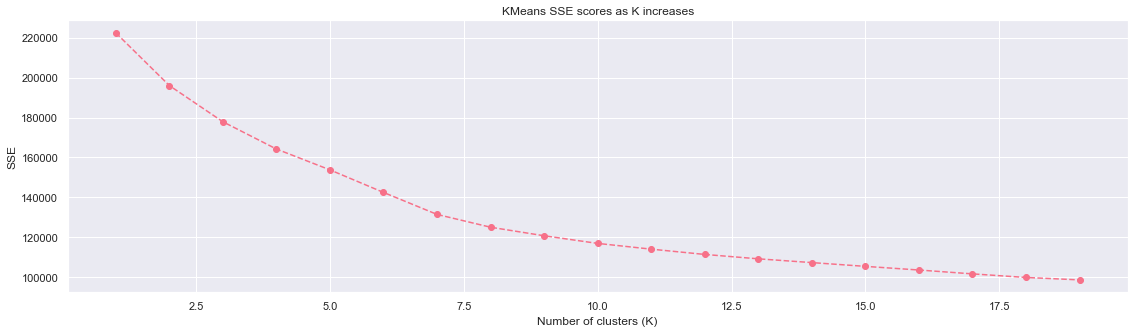

In [66]:
centers = range(1, 20)
plt.plot(centers, scores, linestyle = '--', marker = 'o')
plt.ylabel('SSE')
plt.xlabel('Number of clusters (K)')
plt.title('KMeans SSE scores as K increases')

Graph above shows that k = 20 is the best choice..


Next step is to apply silhouette analysis to determine the degree of separation between clusters if the value:<br>
1) If it's 0 –> the sample is very close to the neighboring clusters<br>
2) It it's 1 –> the sample is far away from the neighboring clusters<br>
3) It it's -1 –> the sample is assigned to the wrong clusters<br>
Therefore, we want the coefficients to be as big as possible and close to 1 to have a good clusters.

In [67]:
# get silhouette samples
for i in range(2, 20):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(master_transactions)
    clusters = kmeans.predict(master_transactions)
    silhouette_avg = silhouette_score(master_transactions, clusters)
    print ('For clusters num = {}, the avg silhouette score is: {})'.format(i, silhouette_avg))
    # print('For clusters num = ' + str(i) + ', the avg silhouette score is: ' + str(silhouette_avg))

For clusters num = 2, the avg silhouette score is: 0.117549322098)
For clusters num = 3, the avg silhouette score is: 0.111254060635)
For clusters num = 4, the avg silhouette score is: 0.12393623792)
For clusters num = 5, the avg silhouette score is: 0.130472578165)
For clusters num = 6, the avg silhouette score is: 0.124536914112)
For clusters num = 7, the avg silhouette score is: 0.138049616195)
For clusters num = 8, the avg silhouette score is: 0.134576352498)
For clusters num = 9, the avg silhouette score is: 0.127293861176)
For clusters num = 10, the avg silhouette score is: 0.122391399278)
For clusters num = 11, the avg silhouette score is: 0.117397593588)
For clusters num = 12, the avg silhouette score is: 0.116013771784)
For clusters num = 13, the avg silhouette score is: 0.114764713985)
For clusters num = 14, the avg silhouette score is: 0.109595705391)
For clusters num = 15, the avg silhouette score is: 0.112377059774)
For clusters num = 16, the avg silhouette score is: 0.108

As above script shows, clusters_num = 7 has the best average silhouette score of around 0.138<br>
Now, the next step is to apply ward emthod to calculate the similarity between the clusters then append the results as a new column to master_transactions

In [68]:
ward_model = AgglomerativeClustering(n_clusters = 7)
master_transactions['cluster'] = ward_model.fit_predict(master_transactions)

In [69]:
master_transactions.sample(10)

,age,avg_spent,bogo_percent_completed,completed_bogo,completed_discount,discount_percent_completed,gender,income,member_since,num_bogos,num_discounts,num_transactions,percent_completed,total_completed,total_received,total_spent,total_viewed,cluster
12792,-1.518342,-0.718590,-0.250296,-1.719354,1.729610,-0.351955,-1.159778,-0.018752,-1.191531,-1.563191,1.965400,-0.841554,0.0,0.0,0.478540,-0.793457,-0.281302,0
3576,0.322524,0.307941,-0.250296,-0.564000,2.876572,-0.351955,0.770364,0.351660,0.996016,-0.609045,1.965400,0.316190,0.0,0.0,0.478540,0.659060,0.493128,2
12492,2.508553,-0.776236,-0.250296,0.591354,-0.564313,-0.351955,0.770364,-1.315194,1.640114,0.345102,-0.518577,0.895062,0.0,0.0,0.478540,-0.646951,-0.281302,6
547,0.264997,-0.200398,-0.250296,-1.719354,0.582649,-0.351955,-1.159778,-0.666973,0.666811,-1.563191,0.475013,-0.455640,0.0,0.0,1.409069,-0.348630,-0.281302,0
12272,-0.022638,0.714832,-0.250296,-0.564000,1.729610,-0.351955,-1.159778,1.555499,-1.184374,-0.609045,1.468604,-1.034512,0.0,0.0,-0.451989,-0.278993,0.493128,2
1516,-1.345761,-0.863333,-0.250296,-0.564000,-0.564313,-0.351955,0.770364,0.351660,-0.948205,-0.609045,0.475013,-1.420426,0.0,0.0,0.478540,-0.891948,-1.055732,0
8844,0.264997,-0.728708,-0.250296,-0.564000,0.582649,-0.351955,-1.159778,-0.852179,-0.511650,-0.609045,0.971809,-0.648597,0.0,0.0,0.478540,-0.773066,0.493128,2
12428,0.667687,0.217213,-0.250296,-1.719354,-0.564313,-0.351955,-1.159778,0.120153,1.024643,-1.563191,0.475013,0.316190,0.0,0.0,-0.451989,0.544872,0.493128,0
10488,-2.036086,-0.795980,-0.250296,0.591354,-0.564313,2.841272,0.770364,-0.944782,-0.845626,0.822175,-1.015373,-0.455640,0.0,0.0,0.478540,-0.798381,-1.055732,3
12946,0.149943,-0.056243,3.995278,-0.564000,-0.564313,-0.351955,0.770364,-0.111355,-0.411457,-1.086118,-0.518577,-1.613384,0.0,0.0,-0.451989,-0.900489,-1.830162,5


In [70]:
# add cluster column back into master dataset
master['cluster'] = master_transactions['cluster']

In [71]:
master.to_csv('transactions_clusters.csv', index = False)

In [72]:
master = pd.read_csv('transactions_clusters.csv')

In [73]:
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 18 columns):
age                           14825 non-null int64
avg_spent                     14492 non-null float64
bogo_percent_completed        14825 non-null int64
completed_bogo                14825 non-null int64
completed_discount            14825 non-null int64
discount_percent_completed    14825 non-null float64
gender                        14825 non-null int64
income                        14825 non-null float64
member_since                  14825 non-null int64
num_bogos                     14825 non-null int64
num_discounts                 14825 non-null int64
num_transactions              14825 non-null int64
percent_completed             14825 non-null int64
total_completed               14825 non-null int64
total_received                14825 non-null int64
total_spent                   14825 non-null float64
total_viewed                  14825 non-null int64
cluster         

# Quick Exploratory Data Analysis On Master DataSet

#### Visualise the average amount spent by customers in each respective cluster

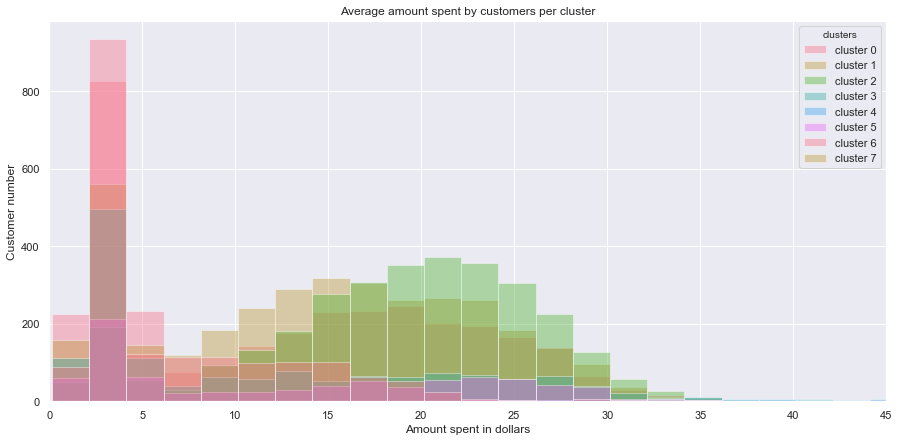

In [74]:
fig, ax = plt.subplots(figsize = (15, 7))
# calculate average spent for each cluster
cluster_0 = master[master['cluster'] == 0]['avg_spent'] 
cluster_1 = master[master['cluster'] == 1]['avg_spent']
cluster_2 = master[master['cluster'] == 2]['avg_spent']
cluster_3 = master[master['cluster'] == 3]['avg_spent']
cluster_4 = master[master['cluster'] == 4]['avg_spent']
cluster_5 = master[master['cluster'] == 5]['avg_spent']
cluster_6 = master[master['cluster'] == 6]['avg_spent']
cluster_7 = master[master['cluster'] == 7]['avg_spent']
avg_bins = np.arange(min(master['avg_spent']), max(master['avg_spent'] + 2), 2)

# plot average spent by all clusters
sns.distplot(cluster_0, kde = False, bins = avg_bins);
sns.distplot(cluster_1, kde = False, bins = avg_bins);
sns.distplot(cluster_2, kde = False, bins = avg_bins);
sns.distplot(cluster_3, kde = False, bins = avg_bins);
sns.distplot(cluster_4, kde = False, bins = avg_bins);
sns.distplot(cluster_5, kde = False, bins = avg_bins);
sns.distplot(cluster_6, kde = False, bins = avg_bins);
sns.distplot(cluster_7, kde = False, bins = avg_bins);

ax.set_xlim([0, 45]);
ax.set_ylabel('Customer number')
ax.set_xlabel('Amount spent in dollars');
ax.set_title('Average amount spent by customers per cluster');
ax.legend(title = 'clusters', labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5', 'cluster 6', 'cluster 7']);


#### Visualise the mean of the how customers completed bogo offers per cluster

Text(0.5,1,'Average times each cluster release a bogo offer')

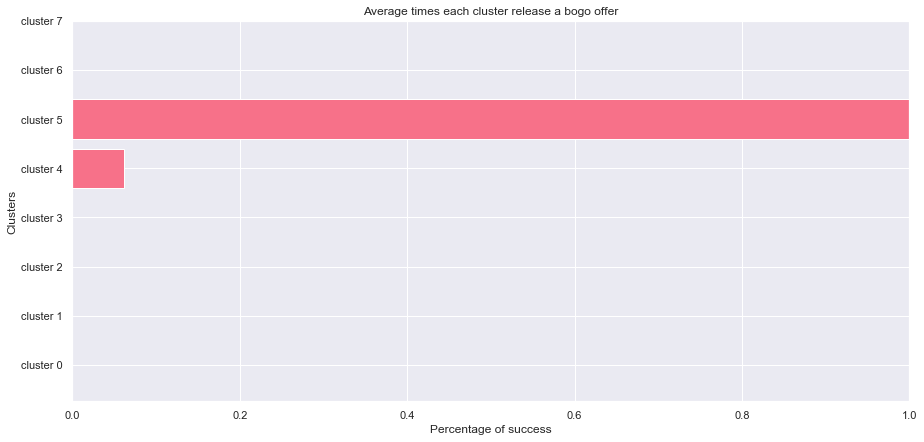

In [75]:
fig, ax = plt.subplots(figsize = (15, 7))
completed_bogo_0 = master[master['cluster'] == 0]['bogo_percent_completed'].mean()
completed_bogo_1 = master[master['cluster'] == 1]['bogo_percent_completed'].mean()
completed_bogo_2 = master[master['cluster'] == 2]['bogo_percent_completed'].mean()
completed_bogo_3 = master[master['cluster'] == 3]['bogo_percent_completed'].mean()
completed_bogo_4 = master[master['cluster'] == 4]['bogo_percent_completed'].mean()
completed_bogo_5 = master[master['cluster'] == 5]['bogo_percent_completed'].mean()
completed_bogo_6 = master[master['cluster'] == 6]['bogo_percent_completed'].mean()
completed_bogo_7 = master[master['cluster'] == 7]['bogo_percent_completed'].mean()
total_bogo = [completed_bogo_0, completed_bogo_1, completed_bogo_2, completed_bogo_3, completed_bogo_4, completed_bogo_5, completed_bogo_6, completed_bogo_7]
bins = np.arange(len(total_bogo))
tick_labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5', 'cluster 6', 'cluster 7']
ax.set_xlim([0, 1])
ax.barh(bins, total_bogo, tick_label = tick_labels)
ax.set_ylabel('Clusters')
ax.set_xlabel('Percentage of success')
ax.set_title('Average times each cluster release a bogo offer')

#### Visualise total number of offers sent to the customers

Text(0.5,1,'Total number of offers sent to customers percluster')

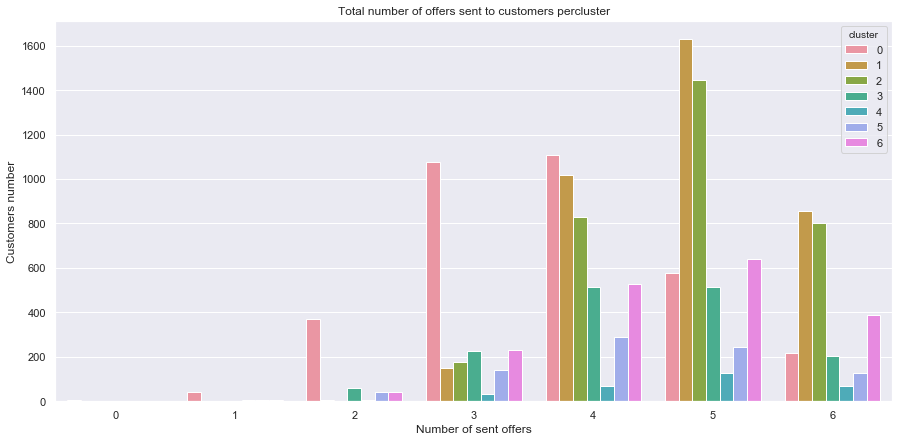

In [76]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.countplot(data = master, x = 'total_received', hue = 'cluster')
ax.set_ylabel('Customers number')
ax.set_xlabel('Number of sent offers')
ax.set_title('Total number of offers sent to customers percluster')

#### Visualise number of BOGO sent to customers

Text(0.5,1,'Total number of sent bogo per cluster')

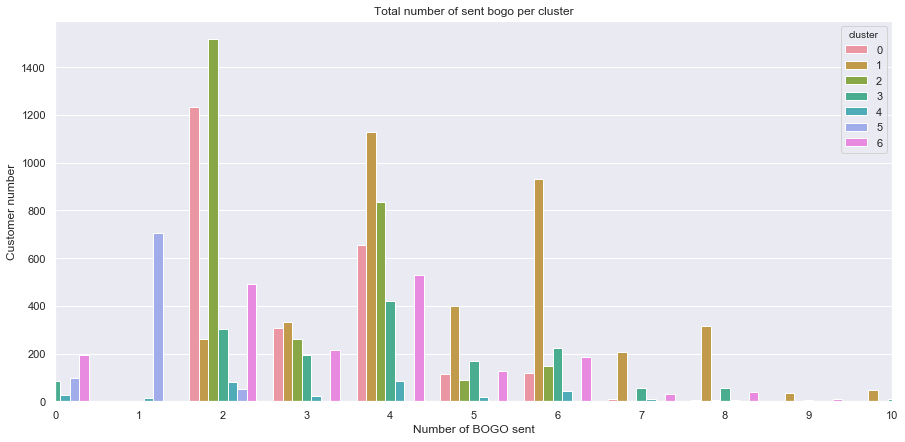

In [78]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.countplot(data = master, x = 'num_bogos', hue = 'cluster')
ax.set_xlim([0, 10])
ax.set_ylabel('Customer number')
ax.set_xlabel('Number of BOGO sent')
ax.set_title('Total number of sent bogo per cluster')

#### Visualise number of discount offers sent to customers

Text(0.5,1,'Total number of sent discount offers per cluster')

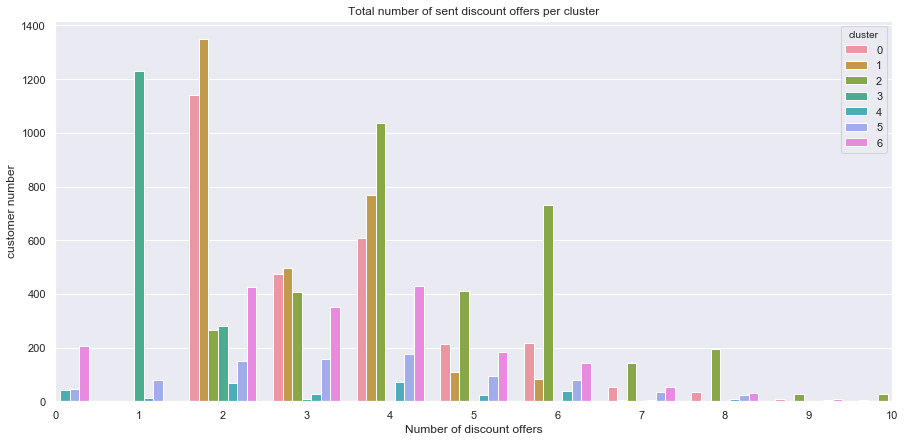

In [79]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.countplot(data = master, x = 'num_discounts', hue = 'cluster')
ax.set_xlim([0, 10])
ax.set_ylabel('customer number')
ax.set_xlabel('Number of discount offers')
ax.set_title('Total number of sent discount offers per cluster')

#### Visualise completed discount offers per cluster

Text(0.5,1,'Average times each cluster relseased a discount offer')

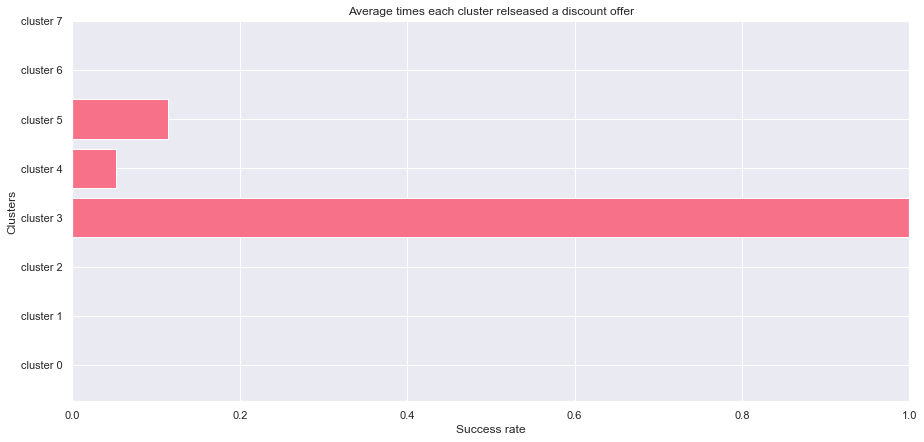

In [80]:
fig, ax = plt.subplots(figsize = (15, 7))
discount_pct_completed_0 = master[master['cluster'] == 0]['discount_percent_completed'].mean()
discount_pct_completed_1 = master[master['cluster'] == 1]['discount_percent_completed'].mean()
discount_pct_completed_2 = master[master['cluster'] == 2]['discount_percent_completed'].mean()
discount_pct_completed_3 = master[master['cluster'] == 3]['discount_percent_completed'].mean()
discount_pct_completed_4 = master[master['cluster'] == 4]['discount_percent_completed'].mean()
discount_pct_completed_5 = master[master['cluster'] == 5]['discount_percent_completed'].mean()
discount_pct_completed_6 = master[master['cluster'] == 6]['discount_percent_completed'].mean()
discount_pct_completed_7 = master[master['cluster'] == 7]['discount_percent_completed'].mean()
discount_pct_completed_data = [discount_pct_completed_0, discount_pct_completed_1, discount_pct_completed_2, discount_pct_completed_3, discount_pct_completed_4, discount_pct_completed_5, discount_pct_completed_6, discount_pct_completed_7]
y_pos = np.arange(len(discount_pct_completed_data))
discount_tick_labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5', 'cluster 6', 'cluster 7']
ax.barh(y_pos, discount_pct_completed_data, tick_label = discount_tick_labels)
ax.set_xlim([0, 1])
ax.set_ylabel('Clusters')
ax.set_xlabel('Success rate')
ax.set_title('Average times each cluster relseased a discount offer')